# Imports

In [24]:
# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss

# Initial TMS Model

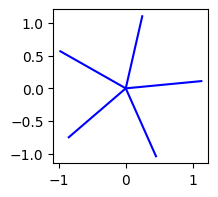

In [25]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3
original_model = "../outputs/toy_models/tms.pt"

tms_model = AutoencoderSymmetric(input_dim=input_dim, hidden_dim=hidden_dim)
tms_model = torch.load(original_model)['model']

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

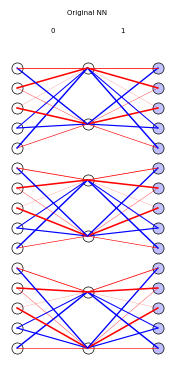

In [32]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3
eigenmodel_path = "../outputs/eigenmodels/tms_parallel.pt"

tms_model_p = torch.load(eigenmodel_path)['model']

model_params = dict(tms_model_p.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

In [57]:
checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']


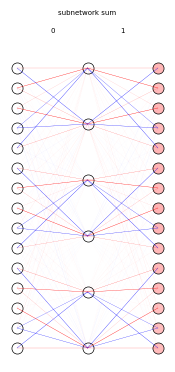

In [58]:
model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}


figs = DrawNeuralNetwork(weights, biases, title='subnetwork sum')

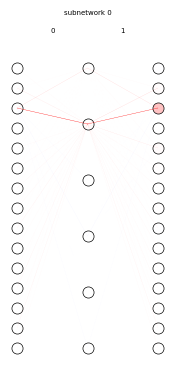

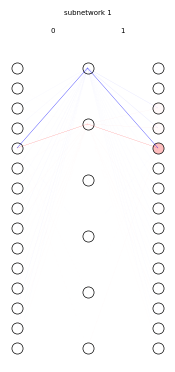

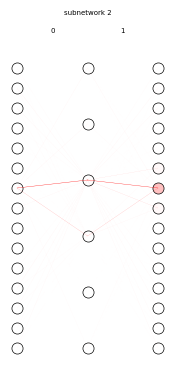

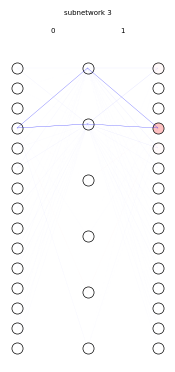

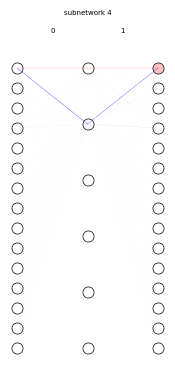

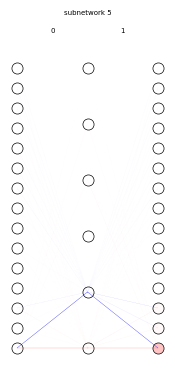

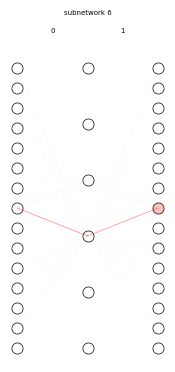

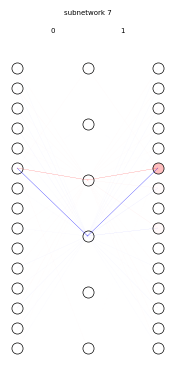

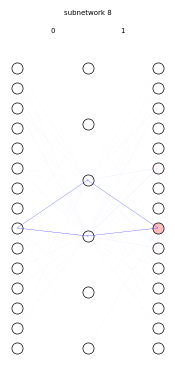

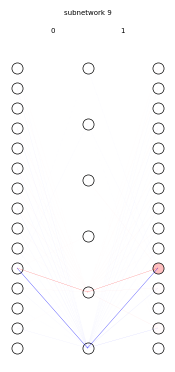

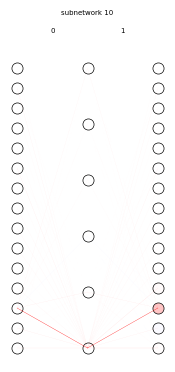

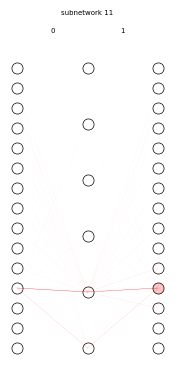

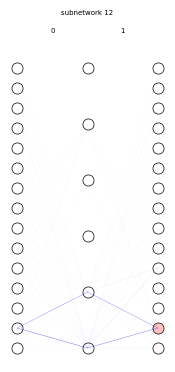

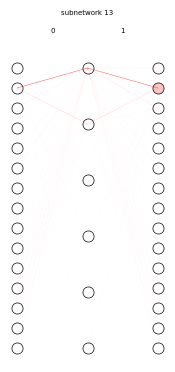

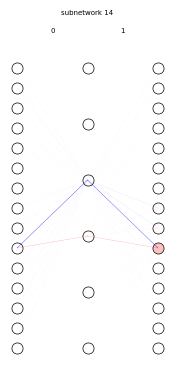

In [59]:
figs = []

for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    
    figs.append(DrawNeuralNetwork(weights, biases, title=f'subnetwork {i}'))

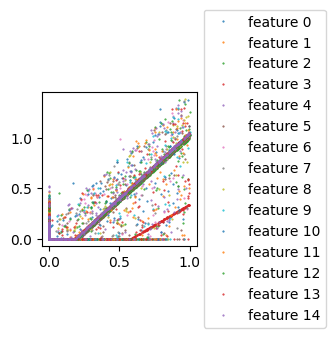

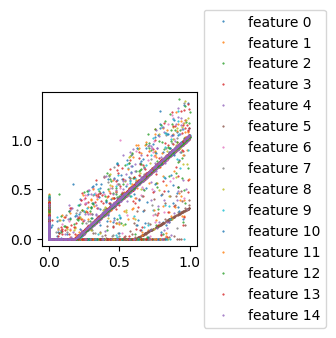

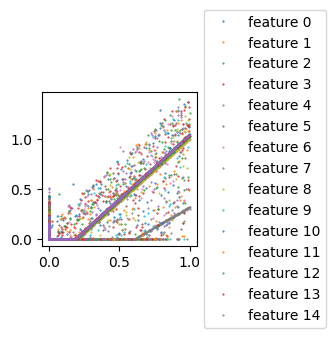

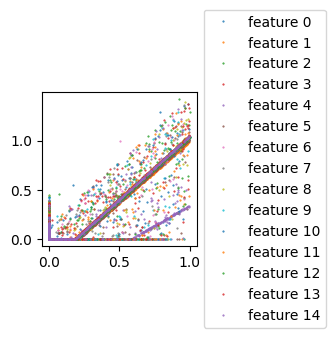

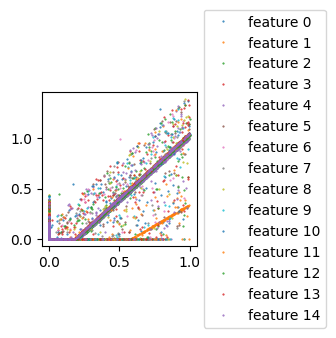

In [70]:
# Geneate sparse features
from toy_models.tms import GenerateTMSData
X, _ = GenerateTMSData(num_features=15, num_datapoints=10000, sparsity=.05, batch_size=32)



feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
toy_model = copy.deepcopy(eigenmodel.model)
orig_y = toy_model(X)
for feature_idx in range(5):
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    feature_coefficients[feature_idx] = -1
    reconstruction = eigenmodel.add_to_network(feature_coefficients)
    # Repalce toy model parameters with model_params
    toy_model.load_state_dict(reconstruction)
    y = (toy_model(X)).cpu().detach().numpy()
    plt.figure(figsize=(2,2))
    for i in range(y.shape[1]):
        plt.plot(X[:,-i].cpu().detach().numpy(), y[:,-i], '.', label=f"feature {i}",  markersize=1) #, bins=np.linspace(-.1,.1,100), alpha=.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()



/root/.eigenestimation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


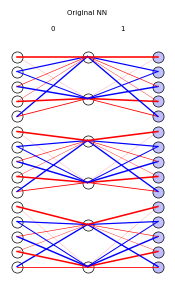

In [17]:
top_samples = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="TopActivatingSamples")



eigenmodel = EigenHora(tms_model_p, None, loss.MSELoss(), len(top_samples), 1, device=device).to(device)
eigenmodel.low_rank = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="subnetworks")

wandb:   1 of 1 files downloaded.  


/root/eigenestimation/notebooks/artifacts/eigenestimation_tms_model_parallel_TopActivatingSamples:v19


wandb:   1 of 1 files downloaded.  


/root/eigenestimation/notebooks/artifacts/eigenestimation_tms_model_parallel_subnetworks:v15
